In [1]:
import tensorflow as tf
from pilco.policies.rbf_policy import RBFPolicy

from tqdm import trange

In [235]:
class RBFPolicy(Policy):

    def __init__(self,
                 state_dim,
                 action_dim,
                 num_rbf_features,
                 dtype,
                 name='rbf_policy',
                 **kwargs):

        super().__init__(state_dim=state_dim,
                         action_dim=action_dim,
                         name=name,
                         **kwargs)

        # Set dtype
        self.dtype = dtype

        # Number of radial basis functions
        self.num_rbf_features = num_rbf_features

        # Set RBF policy locations
        rbf_locs_init = tf.zeros((num_rbf_features, state_dim), dtype=dtype)
        self.rbf_locs = tf.Variable(rbf_locs_init, name='rbf_locs')

        # Set RBF policy lengthscales
        rbf_log_scales_init = tf.zeros((1, state_dim), dtype=dtype)
        self.rbf_log_scales = tf.Variable(rbf_log_scales_init,
                                          name='rbf_log_scales')

        # Set RBF policy weights
        rbf_weights_init = tf.zeros((num_rbf_features,), dtype=dtype)
        self.rbf_weights = tf.Variable(rbf_weights_init,
                                       name='rbf_weights')


    def reset(self):
        # Sample policy parameters from standard normal
        for param in [self.rbf_locs, self.rbf_log_scales, self.rbf_weights]:

            param.assign(tf.random.normal(mean=0, stddev=1, shape=param.shape))


    def match_moments(self, loc, cov):

        # Convert state mean to tensor and reshape to be rank 2
        loc = tf.convert_to_tensor(loc, dtype=self.dtype)
        loc = tf.reshape(loc, (1, self.state_dim))

        # Convert state covariance to tensor and ensure it's a square matrix
        cov = tf.convert_to_tensor(cov, dtype=self.dtype)
        cov = tf.reshape(cov, (self.state_dim, self.state_dim))

        # Compute mean_u
        mean_det_coeff = tf.eye(self.state_dim)
        mean_det_coeff = mean_det_coeff + tf.matmul(cov,
                                        tf.linalg.diag(1. / self.rbf_scales))
        mean_det_coeff = tf.linalg.det(mean_det_coeff) ** -0.5
    
        scales_plus_cov = self.rbf_scales_mat + cov
        scales_plus_cov_inv = tf.linalg.inv(scales_plus_cov)
        
        diff_mui_mus = self.rbf_locs - loc

        mean_u_quad = tf.einsum('ij, jk, ik -> i',
                                diff_mui_mus,
                                scales_plus_cov_inv,
                                diff_mui_mus)

        exp_mean_u_quad = tf.math.exp(-0.5 * mean_u_quad)
        rbf_comp_mean = mean_det_coeff * exp_mean_u_quad

        mean_u = tf.einsum('i, i ->',
                           self.rbf_weights,
                           rbf_comp_mean)

        # Compute cov_su
        Q = tf.einsum('ij, jk, lk -> li',
                      cov,
                      scales_plus_cov_inv,
                      self.rbf_locs)

        Q = Q + tf.einsum('ij, jk, lk -> li',
                          self.rbf_scales_mat,
                          scales_plus_cov_inv,
                          loc)

        Q = Q * rbf_comp_mean[:, None]

        cov_su = tf.einsum('i, ij -> j', self.rbf_weights, Q)

        cov_su = cov_su - mean_u * tf.squeeze(loc)

        # Compute cov_uu
        cov_det_coeff = tf.eye(self.state_dim)
        cov_det_coeff = cov_det_coeff + 2. * cov / self.rbf_scales
        cov_det_coeff = tf.linalg.det(cov_det_coeff) ** -0.5

        half_scales_plus_cov = 0.5 * self.rbf_scales_mat + cov
        half_scales_plus_cov_inv = tf.linalg.inv(half_scales_plus_cov)
        
        muij = (self.rbf_locs[None, :, :] + self.rbf_locs[:, None, :]) / 2
        
        diff_muij_mus = muij - loc[None, :, :]

        diff_mui_muj = self.rbf_locs[None, :, :] - self.rbf_locs[:, None, :]
        
        cov_uu_quad = tf.einsum('ijk, kl, ijl -> ij',
                                diff_muij_mus,
                                half_scales_plus_cov_inv,
                                diff_muij_mus)

        cov_uu_quad = cov_uu_quad + 0.5 * tf.einsum('ijk, k, ijk -> ij',
                                                    diff_mui_muj,
                                                    1. / self.rbf_scales[0],
                                                    diff_mui_muj)

        exp_cov_uu_quad = tf.math.exp(-0.5 * cov_uu_quad)

        S = cov_det_coeff * exp_cov_uu_quad

        cov_uu = tf.einsum('i, ij, j ->',
                           self.rbf_weights,
                           S,
                           self.rbf_weights)

        cov_uu = cov_uu - mean_u ** 2

        return mean_u, cov_su, cov_uu


    @property
    def rbf_scales(self):
        """
        Returns 1 x state_dim tensor of RBF squared lengthscales.
        """

        return tf.math.exp(self.rbf_log_scales) ** 2


    @property
    def rbf_scales_mat(self):
        """
        Returns diagonal state_dim x state_dim tensor
        of RBF squared lengthscales.
        """

        rbf_scales = self.rbf_scales[0]

        return tf.linalg.diag(rbf_scales)


    def call(self, state):

        # Convert state to tensor and reshape to be rank 2
        state = tf.convert_to_tensor(state, dtype=self.dtype)
        state = tf.reshape(state, (1, -1))

        # Compute quadratic form and exponentiate for each component
        diff_state_mui = state - self.rbf_locs
        quad = tf.einsum('ik, lk, ik -> i',
                         diff_state_mui,
                         self.rbf_scales ** -1,
                         diff_state_mui)

        exp_quad = tf.math.exp(-0.5 * quad)

        # RBF output is the weighted sum of rbf components
        rbf = tf.einsum('i, i ->',
                        self.rbf_weights,
                        exp_quad)

        return rbf


In [15]:
rbf_policy = RBFPolicy(2, 1, 5, dtype=tf.float32)
rbf_policy.reset()

In [18]:
loc = tf.zeros(2, dtype=tf.float32)
cov = tf.eye(2, dtype=tf.float32)

mean_u, cov_su, cov_uu = rbf_policy.match_moments(loc, cov)

cov1 = tf.concat([cov, cov_su[None, :]], axis=0)
cov2 = tf.concat([cov_su[:, None], cov_uu[None, None]], axis=0)

cov_full = tf.concat([cov1, cov2], axis=1)

print(tf.reduce_all(tf.cast(tf.linalg.eig(cov_full)[0], dtype=tf.float32) > 0))

print(cov_full)
print(mean_u)
print(cov_su)

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(
[[ 1.          0.          0.02878622]
 [ 0.          1.         -0.11421954]
 [ 0.02878622 -0.11421954  0.14421163]], shape=(3, 3), dtype=float32)
tf.Tensor(-0.17305398, shape=(), dtype=float32)
tf.Tensor([ 0.02878622 -0.11421954], shape=(2,), dtype=float32)


In [21]:
num_samples = 10**4

states = []
actions = []

for i in trange(num_samples):
    
    s = tf.random.normal(mean=0., stddev=1., shape=(2,))
    
    u = rbf_policy(s)
    
    states.append(s)
    actions.append(u)
    
s = tf.convert_to_tensor(states)
u = tf.convert_to_tensor(actions)

100%|██████████| 10000/10000 [00:07<00:00, 1383.06it/s]


In [22]:
emp_mu_u = tf.reduce_mean(u)
emp_mu_s = tf.reduce_mean(s)
(tf.reduce_mean(s * u[:, None], axis=0) - emp_mu_u * emp_mu_s).numpy()

array([ 0.02915221, -0.12850176], dtype=float32)

In [23]:
tf.nn.moments(u, axes=[0])

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.17906179>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.15463084>)

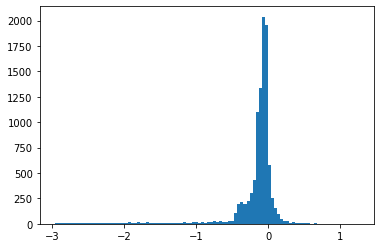

In [24]:
import matplotlib.pyplot as plt

plt.hist(u, bins=100)
plt.show()